## Delivery Time 

In this section we build a predictive model to improve Olist ETA prediction. 

We will use the target variable `wait_time` defined as the difference in number of days between the actual delivery date and the purchase date. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#import data 
from olist.order import Order

In [3]:
orders = Order().get_training_data()

In [4]:
orders.head(2)

,order_id,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,0,0,4,1,1,118.70,22.76,856.292580


### 1 - Baseline

We first need to understand the baseline we want to optimize.

Plot wait_time and expected_wait_time distribution. What’s the median difference ?
What’s the Mean Squared Error for Olist’s current ETA model?

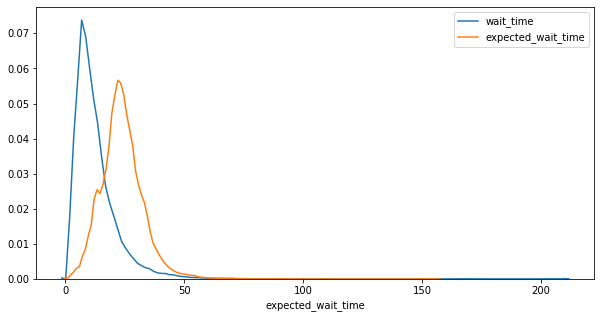

In [5]:
# Plot distribution
sns.distplot(orders['wait_time'], hist=False, label='wait_time')
sns.distplot(orders['expected_wait_time'], hist=False, label='expected_wait_time')

In [6]:
# Compute median
orders[['wait_time', 'expected_wait_time']].median()

wait_time             10.214751
expected_wait_time    23.231574
dtype: float64

In [7]:
# Compute baseline
from sklearn.metrics import mean_squared_error

RMSE = np.mean((orders['wait_time'] - orders['expected_wait_time'])**2)**0.5
print('RMSE: ', RMSE, 'days')

RMSE:  15.129714393149591 days


### 2 - First model 

We can now run a first model to improve. We will use a simple LinearRegression from sklearn as a first pass.

In [8]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [9]:
# Create train and target variable
X=orders[['number_of_products', 'number_of_sellers', 'price', 'freight_value','distance_seller_customer']]
y=orders['wait_time']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [11]:
from sklearn.linear_model import LinearRegression

model_1 = LinearRegression().fit(X=X_train, y=y_train)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE
RMSE = (mean_squared_error(y_true=y_test, y_pred=model_1.predict(X_test)))**0.5
R2 = r2_score(y_test, model_1.predict(X_test))
print(RMSE)
print(R2)

8.673212771684536
0.16468128583807495


In [13]:
list(zip(model_1.coef_, X_train.columns))

[(-0.5502863635286847, 'number_of_products'),
 (-2.9414066323330443, 'number_of_sellers'),
 (0.00024090097491358264, 'price'),
 (0.029355846770380722, 'freight_value'),
 (0.005923344995204305, 'distance_seller_customer')]

### 3 - More Features

We add here additional features from the product details (size, category etc..) and re-run a regression. 

#### Create new X

In [14]:
from olist.data import Olist

In [15]:
data = Olist().get_data()

In [16]:
products = data['olist_products_dataset']
order_items = data['olist_order_items_dataset']

In [17]:
products

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0
...,...,...,...,...,...,...,...,...,...
32946,a0b7d5a992ccda646f2d34e418fff5a0,moveis_decoracao,45.0,67.0,2.0,12300.0,40.0,40.0,40.0
32947,bf4538d88321d0fd4412a93c974510e6,construcao_ferramentas_iluminacao,41.0,971.0,1.0,1700.0,16.0,19.0,16.0
32948,9a7c6041fa9592d9d9ef6cfe62a71f8c,cama_mesa_banho,50.0,799.0,1.0,1400.0,27.0,7.0,27.0
32949,83808703fc0706a22e264b9d75f04a2e,informatica_acessorios,60.0,156.0,2.0,700.0,31.0,13.0,20.0


In [18]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [19]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

,order_id,product_id,order_item_count,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...
102420,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,1,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
102421,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,1,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
102422,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,1,33.0,658.0,3.0,400.0,19.0,9.0,15.0
102423,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,1,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [20]:
order_items_products.nunique()

order_id                      98666
product_id                    32951
order_item_count                 16
product_name_lenght              66
product_description_lenght     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [21]:
order_items_products = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_products

,order_id,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,00010242fe8c5a6d1ba2dd792cb16214,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,35.0,40.0,30.0
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0,89.0,15.0,40.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0,45.0,26.0,38.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0,21.0,24.0,19.0
98664,fffe18544ffabc95dfada21779c9644f,100.0,20.0,20.0,20.0


In [22]:
orders_2 = orders.merge(order_items_products, on="order_id", how="left").dropna()

In [23]:
orders_2.head(2)

,order_id,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,0,0,4,1,1,29.99,8.72,18.063837,500.0,19.0,8.0,13.0
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,0,0,4,1,1,118.70,22.76,856.292580,400.0,19.0,13.0,19.0


In [24]:
X_2 = orders_2.drop(['order_id', 'expected_wait_time', 
                     'delay_vs_expected', 'wait_time', 'dim_is_five_star', 'dim_is_one_star', 'review_score'], axis=1)
y_2 = orders_2['wait_time']

In [25]:
X_2.columns

Index(['number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer', 'product_weight_g_sum',
       'product_length_cm_max', 'product_height_cm_max',
       'product_width_cm_max'],
      dtype='object')

In [26]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.30, random_state=42)

#### Simple linear regression

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

model_2 = make_pipeline(
    StandardScaler(),
    LinearRegression()
)

model_2.fit(X=X_2_train, y=y_2_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [28]:
from sklearn.metrics import mean_squared_error, r2_score

# Compute RMSE
RMSE = (mean_squared_error(y_true=y_2_test, y_pred=model_2.predict(X_2_test)))**0.5
R2 = r2_score(y_2_test, model_2.predict(X_2_test))
print(RMSE)
print(R2)

8.85710960384754
0.1636838573093694


Our models is twice better (8 days RMSE vs. 16) than the exptected_wait_time from the olist dataset.
Let's visualize it!

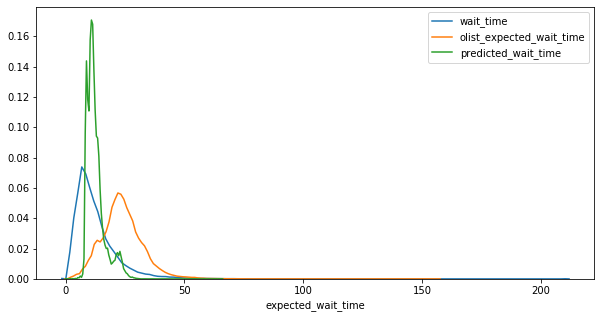

In [29]:
sns.distplot(orders['wait_time'], hist=False, label='wait_time')
sns.distplot(orders['expected_wait_time'], hist=False, label='olist_expected_wait_time')
sns.distplot(model_2.predict(X_2), hist=False, label='predicted_wait_time')

####  Gridsearch with alpha-reg (Ridge) linear regression

In [30]:
# Use a pipeline to preprocess & fit & transform
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
linreg = Ridge()
scaler = StandardScaler()
estimators = [('scaler', scaler), ('linreg', linreg)]
pipe = Pipeline(estimators)

In [31]:
# GridSeachCV on alpha
from sklearn.model_selection import GridSearchCV
param_grid = {
    'linreg__alpha': np.logspace(-4, 1, 50),
}
gridsearch = GridSearchCV(pipe, param_grid, cv=5)
gridsearch.fit(X_2_train, y_2_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linreg',
                                        Ridge(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=None,
                                              normalize=False,
                                              random_state=None, solver='auto',
                                              tol=0.001))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'linreg__alpha': array([1...
       1.84206997e-01, 2.32995181e-01, 2.94705170e-01, 3.72759372e-01,
       4.71486636e-01, 5.96362332e-01, 

In [32]:
print("Best parameter (CV score=%0.4f):" % gridsearch.best_score_)
print(gridsearch.best_params_)

Best parameter (CV score=0.1642):
{'linreg__alpha': 0.0001}


In [33]:
pipe_cv = gridsearch.best_estimator_
pipe_cv

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 Ridge(alpha=0.0001, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

In [34]:
print('R2 score')
pipe_cv.score(X_2_test, y_2_test)

R2 score


0.16368385730422397

In [35]:
print('RMSE')
y_pred = pipe_cv.predict(X_2_test)
mean_squared_error(y_2_test, y_pred)**0.5

RMSE


8.857109603874788

<BarContainer object of 9 artists>

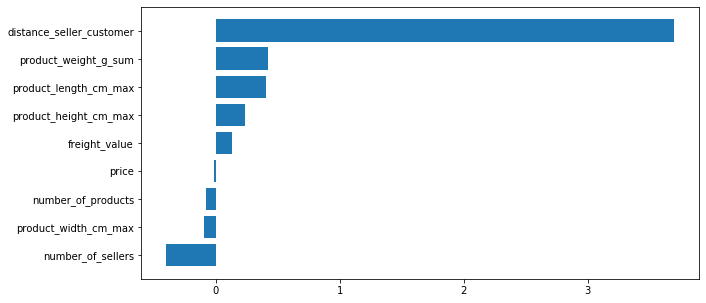

In [36]:
ridge_cv = pipe_cv['linreg']
coefs_cv = list(zip(X_2.columns, ridge_cv.coef_))
coefs_cv_df = pd.DataFrame(coefs_cv, columns=['features', 'coef']).sort_values(by='coef')
coefs_cv_df
#sns.catplot('coef', 'features', data=coefs_cv_df, kind='bar')
plt.barh(coefs_cv_df.features, coefs_cv_df.coef)

### 4 - AutoML

We propose here to use the library [Tpot](http://epistasislab.github.io/tpot/) to find the best model for our optimization function:

In [43]:
# Train TPOT on all my data
from tpot import TPOTRegressor
import os
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2)
tpot.fit(X_2_train, y_2_train)
print(tpot.score(X_2_test, y_2_test))
tpot.export(os.path.join(os.getenv('HOME'),'code','tpot_delivery_time.py'))



TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.4, min_samples_leaf=8, min_samples_split=8, n_estimators=100)
-71.38962669034875


In [48]:
from sklearn.ensemble import RandomForestRegressor
tpot_best_model = RandomForestRegressor(
    bootstrap=True, max_features=0.4, min_samples_leaf=8, min_samples_split=8, n_estimators=100)

In [49]:
tpot_best_model.fit(X_2_train, y_2_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.4, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=8,
                      min_samples_split=8, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [52]:
# RMSE
mean_squared_error(y_2_test, tpot_best_model.predict(X_2_test))**0.5

8.45556754303933

In [53]:
# R2
r2_score(y_2_test, tpot_best_model.predict(X_2_test))

0.2377946938596711